In [1]:
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt

In [59]:
def load_boston(ratio=0.8):
    features, target = datasets.load_boston(True)
    target.shape = -1, 1
#     # normalization
#     X = X/80
#     Y = Y/(np.max(Y) - np.min(Y))
    np.random.seed(4)
    num_samples = len(target)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = features[idx[:num_train]], target[idx[:num_train]]
    validdata = features[idx[num_train:]], target[idx[num_train:]]
    
    return traindata, validdata

In [55]:
def load_dummy(ratio=0.8):
    X = np.linspace(-40, 40, num=2000).reshape(-1, 1)
    Y = 0.02*X**3 + 2*X**2 + 30*X + 300*np.random.randn(*X.shape)

    # normalization
    X = X/80
    Y = Y/(np.max(Y) - np.min(Y))
    
    features, target = X, Y
    target.shape = -1, 1
    num_samples = len(target)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = features[idx[:num_train]], target[idx[:num_train]]
    validdata = features[idx[num_train:]], target[idx[num_train:]]
    
    return traindata, validdata

In [56]:
def load_boston(ratio=0.8):
    X, Y = datasets.load_boston(True)
    Y.shape = -1, 1
    
    # normalization
    X = X/80
    Y = Y/(np.max(Y) - np.min(Y))
    
    num_samples = len(Y)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = X[idx[:num_train]], Y[idx[:num_train]]
    validdata = X[idx[num_train:]], Y[idx[num_train:]]
    
    return traindata, validdata

In [60]:
(X_train, Y_train), (X_valid, Y_valid) = load_boston()

In [61]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(405, 13) (405, 1)
(101, 13) (101, 1)


# MLP Quiz

## 内容

利用$\hat{Y} = f_2\circ\phi\circ f_1 (X)$和梯度下降法来拟合boston数据集，即求解最优化问题：$min_{W, b} L(\hat{Y}, Y)$

其中：

* $Z_0 = X$, 其中 $X \in \mathbb{R}^{N\times n_{in}}$
* $Z_1 = f_1(Z_0) := Z_0W_1^T + b_1$, 其中 $W_1 \in \mathbb{R}^{n_{mid}\times n_{in}}, b_1 \in \mathbb{R}^{n_{mid}}$
* $Z_2 = \phi_2(Z_1) := \frac{1}{1+e^{-Z_1}}$, 其中指数运算为逐元素运算，即$e^{X}_i := e^{X_i}$
* $Z_3 = f_2(Z_2) := Z_2W_2^T + b2$, 其中 $W_2 \in \mathbb{R}^{n_{out}\times n_{mid}}, b_2 \in \mathbb{R}^{n_{out}}$
* $\hat{Y} = Z_3$
* $L(\hat{Y}, Y) := \frac{1}{2} \sum_{i=1}^{N} (\hat{Y_i} - Y_i)^2$

关于boston数据集：$n_{in}=13, n_{out}=1$，为了降低计算量，设定$n_{mid} = 30$

## 评分

1. （4分）给出$\frac{\partial L}{\partial W_1}, \frac{\partial L}{\partial b_1}, \frac{\partial L}{\partial W_2}, \frac{\partial L}{\partial b_2}$的计算表达式，并注明其中每一个矩阵的尺寸（纸质或pdf）
2. （4分）补充完整下述代码
3. （2分）性能：服务器空载情况下运行一次完整的训练时间低于10s （Baseline为3.5s）

## 提交

提交到`ftp://ftp.lflab.cn/AI_homework/Graduate/quiz/`下

## 参考

* 矩阵关于标量的导数：$(\frac{\partial{Y}}{\partial{X}})_{ij} := \frac{\partial{Y_ij}}{\partial{X}}$, 其中 $Y \in \mathbb{R}^{m\times n}, X \in \mathbb{R}$
* 向量关于向量的导数：$(\frac{\partial{Y}}{\partial{X}})_{ij} := \frac{\partial{Y_i}}{\partial{X_j}}$, 其中 $Y \in \mathbb{R}^{m\times 1}, X \in \mathbb{R}^{n\times 1}$
* 标量关于矩阵的导数：$(\frac{\partial{Y}}{\partial{X}})_{ij} := \frac{\partial{Y}}{\partial{X_ij}}$, 其中 $Y \in \mathbb{R}, X \in \mathbb{R}^{m\times n}$

# 实现

$f_1, f_2$称为线性层

In [62]:
class Linear():
    def __init__(self, in_features: int, out_features: int):
        
        self.W=np.random.rand(out_features,in_features)
        self.b=np.zeros((1,out_features))
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        return X.dot(self.W.T)+self.b

$\phi$称为激活函数（非线性层）

In [63]:
class Sigmoid():
    """phi"""
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        return 1/(1+np.exp(-X))

In [64]:
class MLP:
    def __init__(self, in_features: int, mid_features: int, out_features: int):
        self.f1 = Linear(in_features, mid_features)
        self.phi = Sigmoid()
        self.f2 = Linear(mid_features, out_features)
        
    def __call__(self, X):
        return self.f2(self.phi(self.f1(X)))
        
    def forward(self, X):
        Z0 = X
        Z1 = self.f1(X)
        Z2 = self.phi(Z1)
        Z3 = self.f2(Z2)
        return [Z0, Z1, Z2, Z3]
    
    def grad(self, Y, Z): # 3分
        Z0, Z1, Z2, Z3 = Z[0], Z[1], Z[2], Z[3]
        W2=self.f2.W  #1,30
        
        n=Y.shape[0]
        
        dLdW2=(Z3-Y).T.dot(Z2)
        dLdb2=1/n*np.sum((Z3-Y),axis=0).reshape(1,-1)
        
        temp=np.multiply((Z3-Y).dot(W2),Z2)
        dLdW1=np.multiply(temp,(1-Z2)).T.dot(Z0)
        temp=np.multiply((Z3-Y).dot(W2),Z2)
        dLdb1=1.0/30*np.sum(np.multiply(temp,(1-Z2)),axis=0).reshape(1,-1)
        
#         print(dLdW1.shape, dLdb1.shape, dLdW2.shape, dLdb2.shape)
        return dLdW1, dLdb1, dLdW2, dLdb2

In [65]:
def loss(Y_real, Y_pred):
    Y_real=np.array(Y_real)
    Y_pred=np.array(Y_pred)
    return 0.5 * np.sum((Y_real - Y_pred)**2)

In [66]:
class GradientDescent:
    def __init__(self, step=1e-3):
        self.step = step
        
    def update(self, model: MLP, dLdW1, dLdb1, dLdW2, dLdb2):
        """利用梯度dW来更新f的权重"""
        #print(model.f2.b.shape,dLdb1.shape)
        model.f1.W -= self.step*dLdW1
        model.f1.b -= self.step*dLdb1
        model.f2.W -= self.step*dLdW2
        model.f2.b -= self.step*dLdb2
        

In [67]:
%%time
num_features = X_train.shape[-1]
model = MLP(num_features, 30, 1)
opt = GradientDescent(1e-6)

valid_losses = []
train_losses = []
for i in range(1000):
    X, Y = X_train, Y_train
    
    # 1分
    # 1. 计算梯度
    # 2. 更新权重
    Z=model.forward(X)
    dLdW1, dLdb1, dLdW2, dLdb2=model.grad(Y,Z)
    opt.update(model, dLdW1, dLdb1, dLdW2, dLdb2)
    # 3. 存储中间状态
    Y_out = model(X)
    cur_valid_loss = loss(Y_valid, model(X_valid))
    cur_train_loss = loss(Y, Y_out)
    valid_losses.append(cur_valid_loss) 
    train_losses.append(cur_train_loss)
    
    if i%100 == 0:
        print(f"Iter {i}: loss {cur_train_loss:.4f}, valid loss {cur_valid_loss:.4f}")

Iter 0: loss 40103.1810, valid loss 9491.0785
Iter 100: loss 19485.0340, valid loss 4327.9877
Iter 200: loss 17697.0545, valid loss 3875.8296
Iter 300: loss 17542.0032, valid loss 3835.3170
Iter 400: loss 17528.5573, valid loss 3831.4204
Iter 500: loss 17527.3913, valid loss 3830.9696
Iter 600: loss 17527.2902, valid loss 3830.8972
Iter 700: loss 17527.2814, valid loss 3830.8812
Iter 800: loss 17527.2807, valid loss 3830.8769
Iter 900: loss 17527.2806, valid loss 3830.8757
CPU times: user 38.7 s, sys: 1min 15s, total: 1min 53s
Wall time: 4.11 s


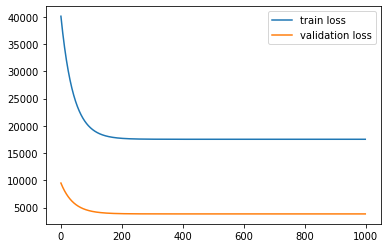

In [68]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train loss", "validation loss"])